<center><img src='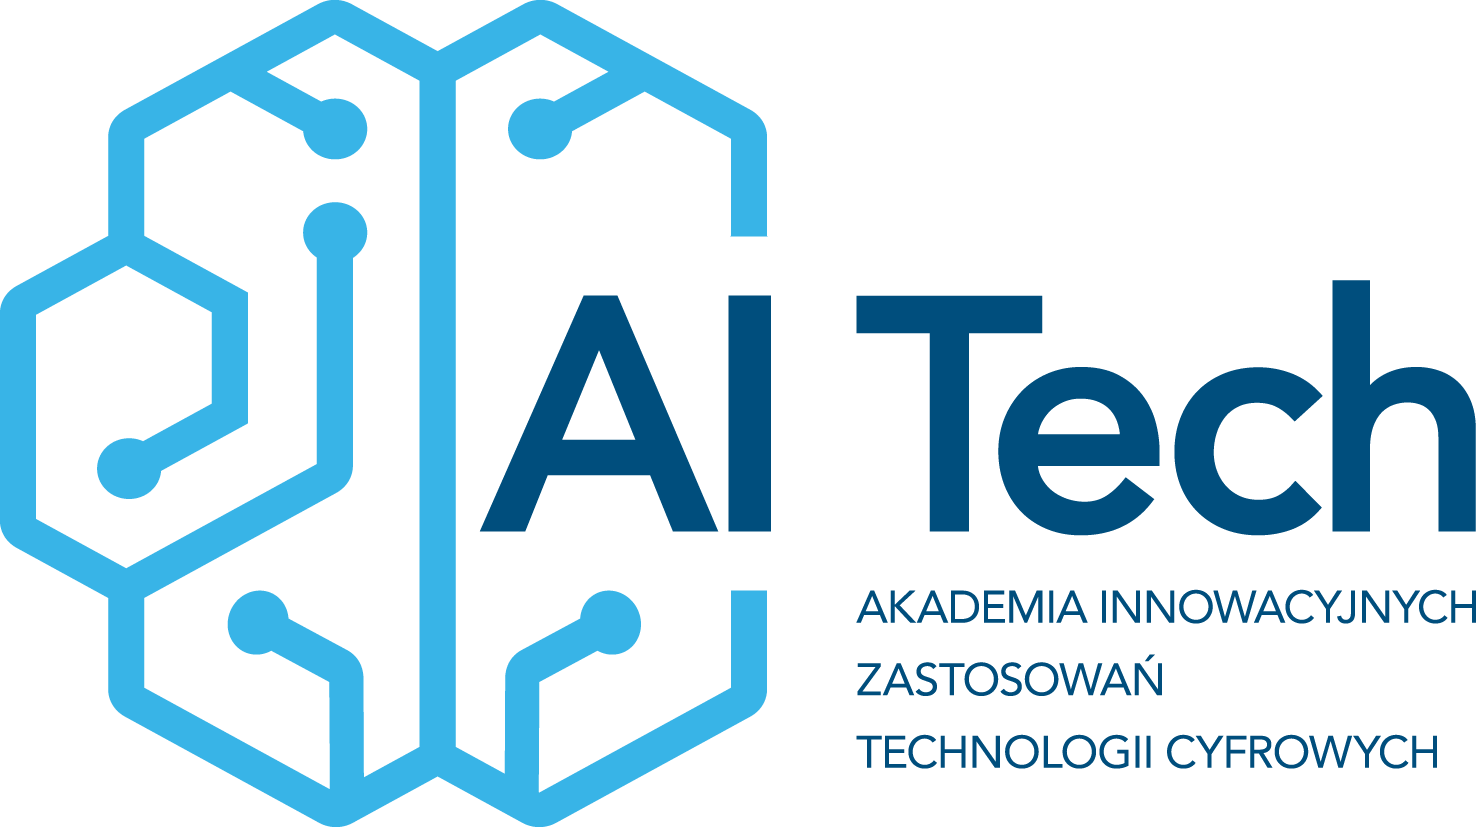
' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center>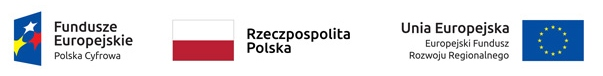</center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Author: Tomasz Pawłowski**




# ML in big scale - Big programming assignment 2

Implement a SVM algorithm on Spark using stochastic gradient descent optimizer. Utilise Optuna to select SGD parameters. Make sure your implementation of SVM allows for Pruning Unpromising Optuna Trials.

The input will be given as `RDD` of pairs $(x_i, y_i)$ consisting of featue vector $x_i \in \mathbb{R}^d$ and label $y_i \in \{-1, 1\}$, where $d$ is a dimension.

Objctive function is given by: 

$$f(w, b) = \lambda w^\top w + \frac{1}{n}\underset{i=1..n}{\sum} max(0, 1 − y_i(w^\top x_i − b))$$

You can assume that gradient of such function is given by:

$$\frac{\delta f}{\delta w_j} = \begin{cases} 
  2\lambda w_j − \frac{1}{n}\underset{i=1..n}{\sum}y_i x_i \qquad\text{  when   }\qquad 1 − y_i(w^\top x_i − b) > 0\\
  2\lambda w_j \qquad\qquad \text{otherwise}
\end{cases}$$


$$\frac{\delta f}{\delta b} = \frac{1}{n}\underset{i=1..n}{\sum}\begin{cases} 
  y_i \qquad\text{  when   }\qquad 1 − y_i(w^\top x_i − b) > 0\\
 0 \qquad\text{otherwise}
\end{cases}$$


Provide an example of using gaussian kernel with your implementation by transforming the feature vectors using RBF ($exp(−γ \|x − l\|^2$) for all landmarks ($l$) in $x_1, x_2, \dots x_n$.


Usage of Optuna should be as follows: 
* Start with multiple variants of parameters. At least percent of data in minibatch and learning rate should be included.
* Repeat model training using successive 10% batches of data.
* In each repetition drop portion of the least promissing sets of parameters.
* In each repetition start from weights calculated in previous step.


In [66]:
!pip install pyspark --quiet
!apt install openjdk-8-jdk-headless &> /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("mlibs") \
                    .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext

In [67]:
import random
from math import exp
import scipy.io
from scipy.spatial.distance import cdist
import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt
import base64

from pyspark import RDD
from typing import TypeVar, Iterable, List, Tuple

In [68]:
!pip install optuna --quiet
import optuna

(21, 2)
(30, 2)


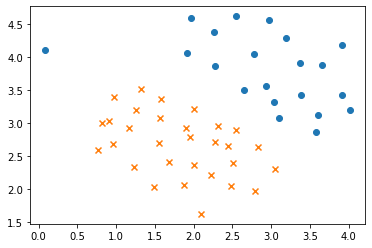

In [69]:
with open("svm1.mat", "wb") as fh:
    fh.write(base64.decodebytes(b'TUFUTEFCIDUuMCBNQVQtZmlsZSwgUGxhdGZvcm06IEdMTlhBNjQsIENyZWF0ZWQgb246IFN1biBOb3YgMTMgMTQ6Mjg6NDMgMjAxMSAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAABSU0PAAAAGwMAAHicRVILUExhFL57d+8+2qu27eVV0iSNkmehsv9XGarxmjLZaNikmEXDlKSShiTs5Fmek5o0aIxHybO8zXhMih5EhJgek5BWVtp1r5r1/3PmzJk5853vfOezpChKI6QoMZel1EDmHzNYT+GC5kLAfTWXZVxM5Pojs6Y3PFxnIm/LM9NqptAorrzr4FYrwRtDurYiUYKN9DHpiHwWe+/p3aOsFHDJ2bhhxBA5xt7LOr041ArDEl4quwPE0CQtcLLXirAjraYsUm+BuN5P0YUNUjw0lqZ2XzSS5JRiz6CRNNQzLj9KUjHIC9qztjVVhuL5sIkOGmLGU21Wn/GuYlFb0WLrGCJFzNbGmZvVBnJr4tFxQ+0oOMd0LQlU/ecbqGprPJdCo8Vn+J2lBWKsf5b94p1Giiq/+c/3NwmRV8puOCcXYfKm8aNH9fSbcYyxPMEf5P7KEs2iMCPRfK5xeWP4RY7EK7ffefKLhDNFB3wFfcTvH2AvWaHgmXeRwlVlHQnl3WSJ/vrr3f3tpKe/Lrnd7SsZULuHjPknmJ7YdAdUx9ULULDr4of2XCGuZPLCiNGVRryX3aDQ58sBh4lw1qZm1qtvnYSfNi+zjfj98Y4scrpCTrcFe5milUicfeinuNkSze/lB88GKnFkrp0uVMuCpT122jeKcYlDL9XJkFhu1/c0Xg7tvB854ZcVyK2TrXbxVCDEyzS6P0mJjKvY9nGOFXShHaKp+6XoWRux5byPAq6HTfvSU63x4JJXfJGARUNE54SbY60H9bI04x69mbfP6rcU9dy2k7ItEMUboskCPv6VYXmFMlQwSlsyW4xTzbcsT5QxcPu0Pb+qRALJco4xy2Acv6iaRpRzwPeYuRQG7iDEqvpWrUcSBX0o70QanrHDPqoP0zhZVVJdHyEx8+W6c+t2MXj8mZxqVgnBmXZqxjRq0KcMXN3TddfXSODPnT3KKMGXfH/PuuFysz7WPFF7FtW94S3FxwXgmmUGZwYOwQv/DE0wkfu1HtxkA+Hp/HSQ4NoFYavOXYqM4NtbHK+JsOxGCEuvUeAvUZResA8AAAAqAAAAeJzjY2BgyABiNiDmgNIgwArlGwMxIxgzMlQCaSaYGBbAgBdApAF/ogGR'))
m = scipy.io.loadmat("svm1.mat")

X_1 = np.array(m['X'])
y_1 = np.reshape(np.array(m['y'], dtype=np.int8), len(m['y']))
print(X_1[y_1 == 1].shape)
print(X_1[y_1 == 0].shape)

plt.scatter(X_1[y_1 == 1][:, 0], X_1[y_1 == 1][:, 1])
plt.scatter(X_1[y_1 == 0][:, 0], X_1[y_1 == 0][:, 1], marker='x')

(480, 2)
(383, 2)


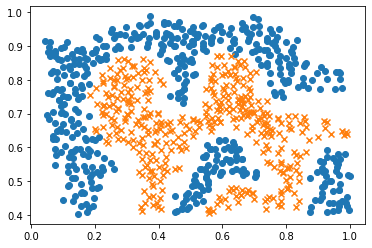

In [70]:
with open("svm2.mat", "wb") as fh:
    fh.write(base64.decodebytes(b'TUFUTEFCIDUuMCBNQVQtZmlsZSwgUGxhdGZvcm06IEdMTlhBNjQsIENyZWF0ZWQgb246IFN1biBOb3YgMTMgMTQ6Mjg6NTQgMjAxMSAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAABSU0PAAAA5RwAAHicdFkHWI3v+z8iMzMr2SPzi5bxDXeEjLKpyG7wRSIzo+wVSUZli6wklWQ2lJIT7ZxK43RWZ5W99T/9zvk873Xl+nO57uu87/M+z/3c43N/7lsLHo/XfRiP11AjG/O0svaPvu734vo8np5G1tP8ddTIJpp/1ZY8XlbGH+uHax5TDb/7mMiKBxTbVnE3qvVDGsB7Yb5C9pzWmzbMX/crnZZIrL4dqp9H20MCOwT7FlFu8LZJ30oqSM/t2Z6LI2S0mq84aDNMTvHBQYOT5ZWkPV1GqR8ivBOeyKizSaerZTdllOJX/aX7XhmV2dl1WPZZxtat/fhi8tJFMmpvnlS0p5WcyQT+5mrDRkK6wev45tLlUvLyXXKsa3wJLbK/EBUSUUxXfHYfaWdZRDGS1MXzc4vJ6Oj2Re/nlNFc81X9u6tKqepVsKrpjnw6Jl742XdrFsn5o3tvr8qgvu791FsCX9Ej94WhYutE6hnxdVPYwGhS+kt2jm4XQc1/GzqH33hIoa+LbZK+PqMol9odEsg9JPK3i18ijVweZBjz8iltXuHo9yj/EcGO09puHxxh94BcCxqFhrrdYxL2NQ2KHydJTybbV7u6/lf0gjzMbhlUeCTRQPNrnx80eELGrr/dlj1Kol4r+L3l+s9pr+tqmZtPMv023/Mt4Vg8O690r3TKzeoYpq++88RLkd5xbL9AnuX91XdSaOTZYzyP9ik0eeUw/+dLnrHzz9Qc3/nz39e0krd2V4OULLpsF/oypWMOycwvlfiF5NEpt48jDCR59MloxtqJGdl0wN5Foncmk+YF978T3yeTvC3yAr/bvqJVwQapH43SKfJV9UWPS2nEj+q7K2NkAV2I1t+b/7yQxYtl9Gm97D9vmcT75KBPX2dtKaQ1NelTAmcV0oOo8e7BE94R8W7anyt+Rx4J0gOtx5XRej8X/xnRZdQ/Q7KuI7+I+V9jnEvFsdw6C/u3O81elFEHt8vncwYJdecI6bPdENPTlUKdnUVkILl7/KGZmMa6uWdZtZPozhPTKEGG384YKYvTdKPDViUiCYkE4gXd5knpllv+LOtCKQUYjIy9cJmTiGetPSvpmmBUiz1bK+mIUblqbONKtl/36GjZ+abcdzgP55iENbv3I1RMISaryWi5iE6at9385CWnF/LNwveB9W6hjA742d7ce13Ozsdz5FumgbC+1U4xDUkY8+9GVyHN8PrQ09CznOqZlyZO71xGe8yOmnRYXsz8Av/XRmGr2wXk69aq29v3ReRnl3A3oHc5889UiWPJ3JZFOjsX0vWMEc1n7iugQW57HzTqkUvNjfxnNZmex9bDP+P4feYW2ZfQcKO5+9cNLyenhAYe7+wlDAd+rXd7PO5iJRU6fZqm7yynhX67NnaOl1Ck02Dj814SZpdLRsmNNv0SMnz4LkjbOHtKOcv/eW5TFGublDG8yDF/muwYVkT/mU+zmVMuoF52MwcfXczpizzQ2i+T5cfgmh6/v2zk08I/Nj9UijSyNj/YUvkthUJqYc7/Bf3iXR22bn0qy9N9QVNvxZ59QpP2zePfuR/L8v42/2R+aZsEln+ONdKhixclMPy5af71ePXTVJZHwBvgEPBplds/+ld/c3iC99FdlwdefhPJcAE4rrnklj6T5dTK+j/DvpsVDFdDvXYerrCupOnWhkufz66kOTw/98zMAoaX2bwSvSaHc+h/4RqXS7bSX21Td2UzOwEXgBu7a+64pE7MpfX2u/ivr+QziX3O+5ok7b+eTSWSo4FJTzKpPKrp2XqDs2iEncWkxNlZNDsj/JpvzBuGM1gHvD7ufmbtDscMXT5l0TSfL70muOQwPbCf9n7ZlMef33TSzxwKMvO0nuqQz+7lwG+8tuW4tzo8KGS/xwVPDDxims/iH783Gf3Jad62gARBBa0PrM5lddAlKq4mbUMe9QtpFJl2N4fdE+vwHt+XGq2Z20bwlsUfcO9W8P22x78UsHhEHiH/oAfyCbKbb67JNDVnZ3wnFFc6z5wioIO+NjdmRb+l/JqR/DMdilm+ok4CN5Vmv64b9yuhExlzP3YOeMfyXZtXnH44D+fgPfbV4hpXn5HvnrWA5l2mu3+Z7v7lDI+Qx9Xxp5RvD4ooe/2lA4WxYlpg8vz99v0SGqk5jWz+xlnE7zDJxuQexpwEjmA9cBv7vg7r5Xt2gpjVgzCDzpnZp8p1+FfGeMY/wcu3Oowupm8dw0fkzS+ikT6GTVt7CpisW58gf9KB7x92l1Pxh4CTnyKF1Nprct6mwArqY23/z4JVYqpyKlgxcoaI4ZrW/hIdX+H0ldDV0mfHpPQneOz2JalSxqOwDnypbUZ9R1FBpQ4XKqkoPir76kk5w88fBjeGh7pVsrqA+oF6wveZFL+ji5Ri7fZXfDcQ0zm/Ac/jznL4ClzVxkWFLn5ETO8JH3ntv28UMTtivZYXCHV2FDF/wj+ok9r8lVOO27n9N5IUdN/oeo9b1UrST9jSsPkOtY5PVNEru5W//6lXRdsN5p37746KCsyMjknNlfRVzN+0b4yC2QH147FBTWXDwwpqFp35emV7FXmHnen4aoOKIv2av1P6q3XxrGb7notvsq9xHLcfpItX3ihbFwUN/djlV/IuuY5vVjCprdsldMds9nyfqZlUYTG+3R+DDFYPUCdQF4DjO3mzzo54eJsul/fLHVzvOnsPfrcjY71Adu45tbZwa/N590v6dsfUZozNXTrU9fzikdJwtg/qAHDAx9x04cG8HIar2nvk6Oq3gOEP8K9RzAb9ooMcHiDfwauBQ8hr8Llf1ybsOPG4nPUB7gZeu4c9rGC8CnwKcQLeg3wGr2nq+96g0w8R2wd5Cf4GiXjS4pmI1X0tH6ygR4Ju/R6sqaDJviHzY/OFVOiX02ruFuFfeYg4hvwSpYqx7FnB7gN+BJlkNmxDNAl1OMetr7X25gEiljeI74YfHdKcgzm+ArxBXtWV4DPABeg/UxAZFnWjnNrxKowsPpWz++A5cAYS+Qqc2SbYVNgpQMz8AQmchV77nVZILY5wvBD7tWx+ZGbBfC7fUb8QD6ivkOivUAfxHHkB/oB1U6K3dm74MZsUNZ0lr5pxdQVxivNQZ8BPDUN6nz75WMDq0ZiMl0fsEvL+4i3vXYab/8h6zfjAZrt3pxYOLaUX8W/iPC+Vsb4Adm/SyfyQdyJnlwZHg8c/XSLR8TYZqy/X6WdAzygOZ13DYv6c9q1g8VWXZ6Pewa+IIxfrL95fbStYfCGe4WfgC+Lb1knTWUdw8QJ94Z+lRsaaFBAzWbfe4Dz4FfmK+EU+go/fi1deGBUuYXUIfWRmSDeflTOfU2LNvKjlvZIYfwWfDRjtN//2gfus70XfCl6K/hkS+6HfRV+J/dHH9hvdRRCWFM3w7zT/3pPbXWMZH47wH216eUQkw1Vj/8bbLY7cYucCT1P+RG37EJnO6izqEPAdeI86g/rzr/VQW//FVbTId8cGebpSNx9RkJ3RiEvXBnK8GnFyKLrnf1feyJhE34j5CPi4myAwQXJOQSZeg6puHVDp7qUm6fo9l1vcriKrMHX64KAqeiPQG6dYqtLlDTdnAZ6ij4VEXqPfQt+srb+ZVGS60WFTIp+mv55R/N4klc0H4Gf0OZgDoR9BH4P5Bfoj8PNnbg9Xb3j9klSuRStXjX/B/Ah/w4+oX9gXfQ+eY76C8zBXQbxg7oB+YGGn+OopJ3IpvMYraMiQMlaXwcvAT7tIh5UvCi5hsoWdR1unVe+YrPscvBh2DHadrnfWi5s/aflZKeO5+B7rwKdPBWf/WKBXQmZSo58njr5l9Rp4+lJya+uxtHyGh+hbIlzNOr9xf8sk+hXw+0mdivPbX+DmKKjvmKfgN/oC8Ff07eDR4E/IB8Qx5hfAu4sS0QSTMo5f4jck5hGIU/Aw8NMZYVmiZX4cjiI/gDM4DzLZxMxr11Quf8BbrbxaNindJmU4DdwC38AcBfhWl98CP4GvwGnwAPAQ4Dv4CfgH9kFdBX6C7wLvTU1+P217Qchwvu45iBvMLYw//is8frSMvYcErz4sqTfog6KMzW96+wytLt5Wyr5Dn4X1eI44zRA3tOkyr5TFM+pi3X4NfSLiGOsxz8F7fF/uM1Bwr3U5m+tAzxSn1pZZ7mVsvgH8rR98fkLVnDTdnCaN/XatZxi3cfhLNm8Bf8ZcFHih5f/Jf803UYfAv4FDWI95TUf+4h5erulsDgzeDtyBBG5hzoL6hPkE5qHo5xAP2vmRhM31MF8Bv0be4lzMP8CPMC8BvgKvgXuwJ+4RFuI0td7KN2w99sU8pe736CswX6nP396I1mUyvgZc/e7e8P2uLm/YOvAq6Aleh3kM5h+Yo2AejHuDf9TlPeDj4F+QWtyU0EZJ1zbPvkr+mpvC7lr9uL4D30GCD6HfQN8KiT4B+oAHo/9AHoO/YY4MHAEvA7/e6hU3b5ujmPUDWnxXM14BeddkupO9g5q9d3a6Es2/oqbezT1WNZuuYhL8IIsSUw6HqHT1WcX6V619q6iRyfDD4ffVrM8FnwB/eODjem1yfxUts/uxrf8olW6epdLNQZU63q74f/VD3wyJ99r/L+DWa5w7w6Pobx6D76An+v2694SeZ2vD2ofTC3069Mf9jws0BWlflS7Pqtj54G/QQ9svV5F8gWSDk10F5Z25dj7klYhEj/qL75+QEM9TKfAy0tSd3s5pveIUZNuli0OvxypKaWC5vZmCk9Wr/Us8u6nogirLWN1LSTMvilqcTZOThmReFI6Q08u5g3bOdlTQw6THzsmblbpzlLT+2gX9y0/ktHDmlMbz5lbSzfhFSxN3yCj6XpuP4VflZJxXaZ0/W0kKq/h+Y31U7Dt908z7Qy4p2P4HJ8cdt/VUsPerGwg3/tbT+EmsKaRj1EzPmABF2MkCJdWa2/KkgtxtaiuBgv0ea7BB1UzGSdPgAR1P5cop9wG/MipITs719nn/aCwncYhe8PkUGbWqv/Cn3g8p/Vhk4+k8UUruOa0TMpZJyGvf5ocHq0Q0qih0eLGtiHo0fPRF/1OF7r5C+vx0f1mcn5COeh+cuLlVBW2JtV0b5y+i4bdydoVfF5F+YkXRY03/HNND46FnUrp67NjtgHcyZiern+l7PrWV0+Z8j8eZtf8vUL5wsNBKSQ6RR7dEnVUyO4sHtI/vH66gCN9xo3c0UFCrQM8e/hpeotWL88PVP9779L+qdH5X07IrY5teSFJTaMT9rzdvqUnctGp961IV3Rwy1cryjIqafogOUJiomV+Cn9Rze7ZHSTukHfrIhijZ991PZ3Q+Uaim0kNOQ/Z/ULPvcF66pb6Z1RHOL4WaMp2+itP7f7Szn8YPW2sRWUUrehXY97+rYvpAP+d16+Z49Kyi5Ji16rsXOH9jPe6F9Sap57MTvdU6f/2tz6BJ5u3t3VV0bP5SjWtVOv9wdtX2DUoauGL+MlcLzq7Gn1sdVXeX0yOzG8NGBFTSTocGNQsmV1J6SkfH1HUyWlOriKWM3uz/pekE5Ww/nGv3p6/P1xZqGvhtzcH3nTj7rplzvb7TdE4ividmOLxM9VAzfRG32nxW0KH+AeOHhHL3v1G6745giprlMe6H8/t2WL6kS6qKfYfnyO/dN37yrsaqmYS+s3yeJu3+qdT2/YYqajZuazdbLy5esA/Og93HnjtgGPRazfTDfe4uMdaUVhWLA+Tnz9dDpmQuVjJ97KepDGYv4CSe/x8AAAD//2VYe1hN6RdGNzQkUoYicqmUFNEMWZUwch0y1SiXSJFL5JIo1yjElIgQiUjKNT9pKpKJiKJQnTpnn30u+1zDKIT8Mnuvbz9Pzj/r6Zy997fWu973XWs3vi59rGCKGvQcK3Idzqig8cAt2zi1EjJnrds7Y6kKhJ8mdWkxVEPTqYVJZ4r4OPbSix2XL6jh+N8dlxXuUkOH/z5qmOLqmT4uVgXDQ/4MDBqtgsNZvl8yriqhhjl5WuyihKIlEepgRwXkvBlh9taCAccuZu86a+XQZB9+xy5DDpPLfR6VrpaBtGvjOmOhFMJjNuXFNkogSm42hHGQgONx2z5HqsQksudK4OCfi1sWTJSCocfmAVPCpaAaV2Ttvk0Kkjs20txEGURtGj5tvakcnjUz3T4YM2D3evL4mhkMSFM6HT/1gI+m537en3FDDfGRsZM39VBBnlh8UeCphDtOF8e4JCigh07A504tcjAMPBO60E1FcHs0zy56ri+PH9bdVLBHdPuAEm52fL2981sFRAwdPdUuU/HDdZters6v8FfC2L5351veU0CHMHVN+M8KOG6nBadTfOzX1CNea6kEUxP9oL7lCvDYuqh0W0cF7IqturlfwYDy8fOZ5UEM9Av6uizwVzmU3FyjvZIqg4vCmOwaLxlMsbDwscqXwrNl1fIVw6VweL/j1YO0BHyuxkdcPyHh+i3h+k9D1f+eKK4fE4OvZeScobkUBO7sWxjTJIKQG8rw3CMiKEn67WxypQjGfS7b9d5EzNUjhsCeIyTGAhrsfhtlOiNYCvrGmcvNXkghb86znbMXyKHsQR/f0rUMVBskbuouVRCce5e4vSrcroRjAuvrL2fzuKcGFDYtdlVw5zKQWbRg8b0oBs4dPJiVUM8QfPB6Nk+G8Gr4x1Wxb/vKSN15xfn+JZskkN7/bKVFCQ3BE1uPu2+lub6IufPFXB8o7nyK/J6qqeyntZJwepBAnE2Cp0O6FIaWnnp+L1JG+oDnz5ip+Wnu/Lbfx+677JxEw/TVJn6h1jRIbU2LbC7TEEAFjBCPk0B18vlTKY8l8GbloYawAVJyX6bDtHHOyVJyTvs6Sgb7P7S6TcPvpyXdTzwUQ3O3thNqKI4XIg4nEccbClatfzprrTkNEbemrLl9SEKeV+as5zRuvxSUqk8pUieeN8ijru9uJKiGykg+qE/kEfY7tubxrRd/yAgemDfy4IGu81ZDFa/PnRc/dzh3SwaWR8vNE2tlEHjWvWtqMe8DeD3qfM62guKdnyUEt9ipt/+aEkZDznYP1yhdGm5c6/nv5XM8b8dP+8t49mKK8x8KPk8wH+y5mYIxZS3lJevFsO58ql7a37yfsL7G14V+cq41Mkbvw48R8WD796M/snmqoejf/T3fm6nh81MHr4qFag5/NRiHT63e2EsDq7wv6PjN0oDjZp0nWw00xFfZ/Hles7pjQD/t70Ppebx/oR7QZ9j6ef9A30B/Y3nD+zXLHyWHC69DjKhT9HPUpWi5E71qSJs/Hg4beEikJM9jdaclcZjZkkUWpRrO57UEL8QJ5wfm1a9a4fZyblv93Jxi+6+BK4v6vV06VkP8uv11LJ/531m9qjmdqwjPELd1vfcLTV7KCW9RB8jv2ocb5paF8jpj/Z4G/44xkS2dxURn7FwREV2hHtB3ke/oC/5r13qvHiQn399MUGUkveL5h/p/1EY14QReF3hf4a7TLttbZbBSV7zhayfe39CX0K/YftNcX2hw/2m9xpChiU+jblAP7JwRQ9Jni32dvlLET9j5REGtS6D9hBiK6zsFAzdmVGzu9qPfYMS5gRG/j807tyI/TgSGzw9MeuEnIs9DXH0qbpaUhfDzHnWOfdjVh6k1q6B/0H/A716d/5hHcfrgnz+9ocMooTt/Lv7O8kBE6saI+eD1iAerAzE3r3h8MbL6lxAfRf+s9Y3b/MccObif3Nvr2FMZVA3Luz/0upzsQ6u+E8GZgZsDvz2xLJSDMM7PYc87vr+sP0gJT9Cf2s8vxA9xQP8j86d12LYP3WUQMXn+Ec+NcrLX4FxF3oVYvZphc4X3Ocwb68B5jnsbqz8J5z/83ER+4P6CfoH1tok6zH8yz2fkN+aHe1v7uc/6uIKrV8nxRUm+x+tRb4f7TXrZt0xO8EX88flsngrir0MvbNyTmc3AQeV6S5UNv6/ifahb9H/co1ieKLg5qyJ1o+/iHEC/Q7+N9tH9Nn8qvyeyvGUI7tgn9CfcQ5B3uL8N1L/TrPeeJnMT80U80MdxT0F/Qd9oP0dx7rePyCOsH+9n55uE5Ic+g/igr2IdmCfyDJ+Pc7f93srORynxZYys30vI9fh8dr7y+5nePbouf4+M7Mmmo+2vOaXIf6gHdYd8RD3jfoh7BPoaq0MhXK+KLKo8SMHU4EWSoHLexybtMhkf409Bz4IDgXlDxOC0sXhamJKGdf8tWjS8csy57WJLgbnHkRTX2SIYkbgx/dBm3l8U0TPdo8eIYfW9OQF3p1HkHPM2WnutosD6bV4vdVEbXtkjo66kMZzeVbD4QebL4ssabp/SwFz/ec0BxlrQSS5NSXBXwacdWeN3jFTC+kAjzRI9JXzJKo3K2qCA1mq6sPoOA16eH83caTmJ745mDTixlIG7FVaTn9krwED1zVz2WAH5W1X3I9OV0HFVll/wFxVXjwZyW492+PJCDacveehcW8mfh8+/LbWyUSyWw618A6bQnIHiFtj7aR0D2RmquBxDIdhcC92SP6QBViY1nYhTCGDqq+mFNbI6+Id6ckXWoQ5ylnzvUC2sZez7N4TXwWtDvZUGVvXgmz394/loIVyy65pvHSmC16l+Pc8MpeCv3VHj4mJFwDiWjXIwaHufcSv42XlhA5Q/+f4RwCWjwY3mZXUQlNkUnW5RB3fOJvW4fKkWZAY573SLRaBydrW2niTk3o8aYJ5pTICJqwCc/ATblv7K54Xfv4nbcGnrs3oYeTL0WNpbIcdTEcyel7bD9xYFwS+M75YHisFvRYEwpLRNb0GUKjRABE/jXG8e6i0C5zfpfZu3NJD6MB/W9xpA4uXa9upbT/JHnBbPK/gy87AAcmf6H/SxFIC93rmvRlf5fDDOLp5eV3S9nuMnHxFHReqG+KM6AoKH5l22kSq+luSBdeLzsV+ID0bEuX3EfOsXumrnZ/P93DB+2Rmn1hqCG/aN9RURtwcIOf4ICU4PI5K8IjwauPcsIeER1nutxeonnaN8nYhPe16x/eDrxPoQZ+QB4oT3f3KU5QyR1JI6qBsbwq6OreVx5XiYvCbKd423mPyNdWL/T97Prb3fIIKR0zO6Tj4vgiXq3cmiKiGkBX9/Eeb5WmmpN2ugTx14qKen/du3FsZkm3TKK6khfcH+YsS8B3dbHWo4SwQFv/hnuarrCf7IY6wDz0P8B9G/21JdKHiycGB4UIWI4Is43ItPsk/cKABRs26cRttA6kO+nzHT+vdZ3sjNmUbOpxrh+3rrkaOF5pT+JklnG6HBPKe6f7MWjrzOLajv2QiT3hQdUfsq4GzVAs+6a0pY0/3VCqMtKhhS1jDnabKK+NdjI39pl90KePpL2yR9xMCeASdnWQxn4Hn81Yuxc+UcL+QcL2UcX2RgEO19P/qZlKtDCl9DXIJWF0pgrjrEXPlBwvm+DDrZmrvbTpLDguFp+YNnSiHhrfWRN7sl3LyWcHsGDd2+XNzzNZWGb4neGcd0JCSyONPc/KFhn75NRNc8MTevKAgd5uUxSNOGa69kundnFdj2N6seNEgJLntDc/cWKGDiP+nexb34v7v0Nl/Qw1jB8UcOH5R0WqNWxulBBhP07kbox8uh+3Jv0dITckhcUKX12cFweyTD7XkKbg9QcvuGkpyPfm39vuXwRwEfEWf08dJ8qyW5n5SwZYZRV6/Ktrlzfue+S0IV+Rv9H+/H/PH7q643BrvNUIKu/IC1Jl7M7b9iohNWR2JIOf79Q3H/T/gxIn7o+6gr9An83n7Qvkf9FvHX4zxA33BzEOSNfN5AfON9fbZdpZ+A+APqDSPqfebwGLcRa2uJjnCeYESfQP9GH/zFU3DSS5/3EdQb1nX+daVLVSOvuyEBoz4tOyEk96HuvDNrdLLdeP+40Em7uXU0xb2Hiwm++Hz0S/RBzBt9/v8NnMS0DwAAAD8AAAB4nONjYGCYwMzAwAakORggNAiwQvnxQDlGBhBmZKgE0kwwsaEOGAYeUN/ddA4DCkymr0MpT650tp0BAIEaA+U='))
m = scipy.io.loadmat("svm2.mat")

X_2 = np.array(m['X'])
y_2 = np.reshape(np.array(m['y'], dtype=np.int8), len(m['y']))
print(X_2[y_2 == 1].shape)
print(X_2[y_2 == 0].shape)

plt.scatter(X_2[y_2 == 1][:, 0], X_2[y_2 == 1][:, 1])
plt.scatter(X_2[y_2 == 0][:, 0], X_2[y_2 == 0][:, 1], marker='x')

In [71]:
y_1[y_1==0] = -1
data_1 = np.hstack((X_1, y_1.reshape(-1, 1)))
data_1 = sc.parallelize(data_1)
data_1.take(10)

[array([1.9643, 4.5957, 1.    ]),
 array([2.2753, 3.8589, 1.    ]),
 array([2.9781, 4.5651, 1.    ]),
 array([2.932 , 3.5519, 1.    ]),
 array([3.5772, 2.856 , 1.    ]),
 array([4.015 , 3.1937, 1.    ]),
 array([3.3814, 3.4291, 1.    ]),
 array([3.9113, 4.1761, 1.    ]),
 array([2.7822, 4.0431, 1.    ]),
 array([2.5518, 4.6162, 1.    ])]

In [72]:
class SVM():
    def __init__(self, n_feature, lambda_: float=1):
        self.W = np.random.uniform(size=n_feature)
        self.b = np.random.uniform(size=1)
        self.lambda_ = lambda_

    def fit(self, data: RDD[List[float]], lr: float=0.05, p: float=0.5, epochs: int=100, quiet: bool=True):
        for _ in range(epochs):
            self.mini_batch_step(data, lr, p)
      
            if not quiet:
                print(self.W, self.b)
                print(self.loss(data))

    def full_batch_step(self, x: RDD[List[float]], lr: float) -> List[float]:
        x = x.map(lambda el: np.array(el))
        cond = x.map(lambda el: self.L(el) > 0)
        n = x.count()
    
        y = x.map(lambda el: el[-1])
        b_grad = y.zip(cond).map(lambda el: el[0] * el[1])
        b_grad = b_grad.mean()
        self.b = self.b - lr * b_grad

        x_with_cond = x.zip(cond).map(lambda el: np.hstack(el))
        W_grads = x_with_cond.map(lambda el: 1/n * (el[-2] * el[:-2]) * el[-1])
        W_grads = W_grads.reduce(lambda a, b: np.sum([a, b], axis=0))
        W_grads = 2 * self.lambda_ * self.W - W_grads
        self.W = self.W - lr * W_grads

    def mini_batch_step(self, x: RDD[List[float]], lr: float, p: float=0.5) -> List[float]:
        sample = x.sample(True, p)
        self.full_batch_step(sample, lr)

    def decision_function(self, xy: np.array):
        dec = self.W @ xy.T
        return dec - self.b

    def loss(self, x: RDD[np.array]):
          losses = x.map(lambda el: self.L(el))
          return self.lambda_ * self.W.T @ self.W + losses.mean()

    def L(self, x: np.array) -> float:
         return np.max([0, 1 - x[-1] * (self.W.T @ x[:-1] - self.b)])

clf = SVM(X_1.shape[1])
clf.fit(data_1, epochs=50, quiet=False)

[0.42307788 0.09326059] [0.86528302]
[0.98909543]
[0.3305831  0.02412303] [0.89278302]
[0.90944576]
[0.30032189 0.01439008] [0.90407334]
[0.89192357]
[0.25990042 0.00541393] [0.91478762]
[0.87246217]
[0.25910305 0.00607854] [0.92145429]
[0.87098169]
[0.28190215 0.0684151 ] [0.91263076]
[0.8864585]
[0.23270694 0.02084492] [0.93263076]
[0.85982024]
[0.22504335 0.02139418] [0.93888076]
[0.85622448]
[0.21696852 0.05671101] [0.93888076]
[0.85640072]
[0.20678036 0.04222121] [0.94975033]
[0.85007612]
[0.17079407 0.01877851] [0.96513494]
[0.83704544]
[0.14629621 0.0102929 ] [0.97720391]
[0.83008911]
[ 0.13075333 -0.00921334] [0.9924213]
[0.82512295]
[ 0.11946762 -0.0173114 ] [1.00605766]
[0.82158318]
[ 0.12833569 -0.01592593] [1.01272433]
[0.82140691]
[ 0.09843568 -0.02711963] [1.02724046]
[0.81838787]
[ 0.10430563 -0.02516952] [1.03279601]
[0.81720746]
[0.11504467 0.00028848] [1.03279601]
[0.81607135]
[0.10019771 0.00056267] [1.04366558]
[0.81288087]
[ 0.08309331 -0.01302602] [1.05652272]
[0.

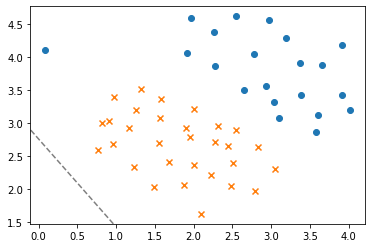

In [73]:
plt.scatter(X_1[y_1 == 1][:, 0], X_1[y_1 == 1][:, 1])
plt.scatter(X_1[y_1 == -1][:, 0], X_1[y_1 == -1][:, 1], marker='x')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xlin = np.linspace(xlim[0], xlim[1], 30)
ylin = np.linspace(ylim[0], ylim[1], 30)
Y_grid, X_grid = np.meshgrid(ylin, xlin)
xy = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
P = clf.decision_function(xy).reshape(X_grid.shape)

ax.contour(X_grid, Y_grid, P, colors='k',
           levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

In [74]:
SIGMA=0.05

def gaussian_kernel(x, a):
    dist = cdist(x, a)
    return np.exp(-0.5 * dist**2 / SIGMA**2)

X_2_mod = gaussian_kernel(X_2, X_2)
print(X_2_mod.shape)

y_2[y_2==0] = -1
data_2 = np.hstack((X_2_mod, y_2.reshape(-1, 1)))
data_2 = sc.parallelize(data_2)
data_2.take(2)

clf = SVM(X_2_mod.shape[1])
clf.fit(data_2, epochs=50)

(863, 863)


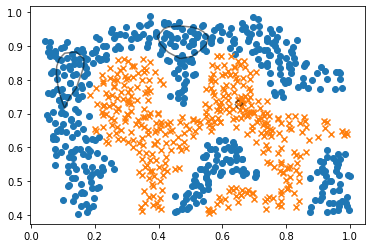

In [75]:
plt.scatter(X_2[y_2 == 1][:, 0], X_2[y_2 == 1][:, 1])
plt.scatter(X_2[y_2 == -1][:, 0], X_2[y_2 == -1][:, 1], marker='x')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xlin = np.linspace(xlim[0], xlim[1], 30)
ylin = np.linspace(ylim[0], ylim[1], 30)
Y_grid, X_grid = np.meshgrid(ylin, xlin)
xy = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
P = clf.decision_function(gaussian_kernel(xy, X_2)).reshape(X_grid.shape)

ax.contour(X_grid, Y_grid, P, colors='k',
           levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

In [86]:
def objective(trial):
    lr = trial.suggest_float("lr", 0.001, 0.1)
    p = trial.suggest_float("p", 0.1, 1.0)

    clf = SVM(X_1.shape[1])
    for step in range(100):
        clf.mini_batch_step(data_1, lr, p)

        intermediate_loss = clf.loss(data_1)
        trial.report(intermediate_loss, step)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return clf.loss(data_1)

In [87]:
%%time
study = optuna.create_study(study_name="SVN", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=15)

[I 2023-02-09 23:16:08,475] A new study created in memory with name: SVN
[I 2023-02-09 23:16:54,490] Trial 0 finished with value: 0.781870917420674 and parameters: {'lr': 0.02623218643021334, 'p': 0.48796424314947084}. Best is trial 0 with value: 0.781870917420674.
[I 2023-02-09 23:17:41,384] Trial 1 finished with value: 0.7977863069593274 and parameters: {'lr': 0.06865663656085638, 'p': 0.5621997895328565}. Best is trial 0 with value: 0.781870917420674.
[I 2023-02-09 23:18:26,496] Trial 2 finished with value: 0.8594582430055319 and parameters: {'lr': 0.027714440874421174, 'p': 0.5316586911268326}. Best is trial 0 with value: 0.781870917420674.
[I 2023-02-09 23:19:10,929] Trial 3 finished with value: 0.7808264933875718 and parameters: {'lr': 0.05439412934051716, 'p': 0.9263983896624107}. Best is trial 3 with value: 0.7808264933875718.
[I 2023-02-09 23:19:55,618] Trial 4 finished with value: 0.7968057960141691 and parameters: {'lr': 0.058226660340682024, 'p': 0.35453335189839863}. Best 

CPU times: user 38 s, sys: 4.62 s, total: 42.6 s
Wall time: 5min 33s


In [88]:
print("Best Params : {}".format(study.best_params))
print("\nBest Loss : {}".format(study.best_value))

Best Params : {'lr': 0.09626757958458713, 'p': 0.9817567124552141}

Best MSE : 0.7485499430154472


<center>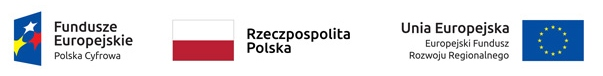</center>